### Clustering Dive Spots based on Location

In [3]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from geopy.distance import geodesic

In [35]:
known_centroids = {
    'Northern Red Sea': {'center': (27.2579, 33.8116), 'radius_km': 150},  # Hurghada, Sharm El Sheikh, Ras Mohammed
    'Southern Red Sea': {'center': (24.7743, 35.1459), 'radius_km': 100},  # Marsa Alam, Elphinstone
    'Cyprus and Eastern Mediterranean': {'center': (34.6700, 33.0410), 'radius_km': 120},  # Cyprus, Israel coast
    'Malta and Gozo': {'center': (35.9375, 14.3754), 'radius_km': 50},  # Malta, Gozo
    'Bali and Nusa Penida': {'center': (-8.4095, 115.1889), 'radius_km': 80},  # Bali, Nusa Penida
    'Komodo and Flores': {'center': (-8.6558, 120.3055), 'radius_km': 100},  # Komodo, Labuan Bajo
    'Andaman Sea - Thailand': {'center': (7.8804, 98.3923), 'radius_km': 150},  # Phuket, Similan Islands, Koh Phi Phi
    'Greek Islands': {'center': (37.9838, 24.0159), 'radius_km': 150},  # Cyclades, Dodecanese
    'Maldives Central Atolls': {'center': (3.2028, 73.2207), 'radius_km': 200},  # North and South Male Atolls
    'Caribbean - Cozumel': {'center': (20.4229, -86.9223), 'radius_km': 50},  # Cozumel, Playa del Carmen
    'Caribbean - Bahamas': {'center': (25.0343, -77.3963), 'radius_km': 100},  # Nassau, Exuma, Tiger Beach
    'Caribbean - Bonaire': {'center': (12.1784, -68.2385), 'radius_km': 30},  # Bonaire
    'Caribbean - Cayman Islands': {'center': (19.3133, -81.2546), 'radius_km': 40},  # Grand Cayman, Little Cayman
    'Central Philippines': {'center': (11.9674, 121.9254), 'radius_km': 150},  # Boracay, Cebu, Bohol
    'Palawan and Tubbataha Reef': {'center': (9.7332, 118.9660), 'radius_km': 150},  # Palawan, Tubbataha Reef
    'Raja Ampat': {'center': (-0.2346, 130.5205), 'radius_km': 150},  # Raja Ampat, West Papua
    'Micronesia - Palau': {'center': (7.5150, 134.5825), 'radius_km': 100},  # Palau, Jellyfish Lake
    'Hawaiian Islands': {'center': (20.7967, -156.3319), 'radius_km': 150},  # Maui, Kona, Oahu
    'Socorro and Revillagigedo Islands': {'center': (18.7811, -110.9516), 'radius_km': 100},  # Socorro, San Benedicto
    'Northern Great Barrier Reef': {'center': (-14.9255, 145.7754), 'radius_km': 150},  # Cairns, Lizard Island
    'Southern Great Barrier Reef': {'center': (-23.4426, 151.9068), 'radius_km': 200},  # Bundaberg, Lady Elliot Island
    'Mozambique Channel': {'center': (-14.9350, 40.5796), 'radius_km': 200},  # Mozambique, Madagascar coast
    'Canary Islands': {'center': (28.2916, -16.6291), 'radius_km': 150},  # Tenerife, Lanzarote, Fuerteventura
    'Azores': {'center': (37.7412, -25.6756), 'radius_km': 50},  # Sao Miguel, Pico
    'Galápagos Islands': {'center': (-0.9538, -90.9656), 'radius_km': 100},  # Galápagos Archipelago
    'Fiji Islands': {'center': (-17.7134, 178.0650), 'radius_km': 200},  # Viti Levu, Vanua Levu
    'Andaman and Nicobar Islands': {'center': (11.7401, 92.6586), 'radius_km': 150},  # Havelock, Neil Island
    'Florida Keys': {'center': (24.5551, -81.7800), 'radius_km': 30},  # Key Largo, Islamorada
    'South China Sea - Vietnam': {'center': (11.0056, 109.2000), 'radius_km': 100},  # Nha Trang, Con Dao
    'South Pacific - French Polynesia': {'center': (-17.6509, -149.4260), 'radius_km': 200},  # Bora Bora, Rangiroa
    'South Pacific - Cook Islands': {'center': (-21.2367, -159.7777), 'radius_km': 50},  # Rarotonga, Aitutaki
    'South Australia - Great Australian Bight': {'center': (-32.8014, 133.8624), 'radius_km': 200},  # Neptune Islands, Eyre Peninsula
}

In [4]:
# Load your dataset (adjust the file path as necessary)
dive_sites_df = pd.read_excel('dive_sites_details.xlsx')

df = pd.DataFrame()

# Extract latitude and longitude
df[['Latitude', 'Longitude']] = dive_sites_df['Location'].str.split(', ', expand=True).astype(float)

df['Name'] = dive_sites_df['Title']


In [5]:
# Filter rows where latitude or longitude are out of range
invalid_coords = df[(df['Latitude'] < -90) | (df['Latitude'] > 90) | 
                    (df['Longitude'] < -180) | (df['Longitude'] > 180)]

# Display the names and coordinates of invalid entries
print("Dive sites with invalid coordinates:")

pd.options.display.float_format = '{:.3f}'.format

print(len(invalid_coords))

invalid_coords[['Name', 'Latitude', 'Longitude']]

Dive sites with invalid coordinates:
0


,Name,Latitude,Longitude


In [6]:
# Convert latitude and longitude into radians for DBSCAN
coords = np.radians(df[['Latitude', 'Longitude']])

# Use DBSCAN for geospatial clustering
db = DBSCAN(eps=0.1, min_samples=2, metric='haversine').fit(coords)
df['Cluster'] = db.labels_

# Calculate centroids of clusters
cluster_centroids = df.groupby('Cluster')[['Latitude', 'Longitude']].mean()

In [72]:
# Function to assign regions based on proximity within radius of known centroids
def get_nearest_region(lat, lon, known_centroids):
    for region, info in known_centroids.items():
        center = info['center']
        radius_km = info['radius_km']
        dist = geodesic((lat, lon), center).km
        if dist <= radius_km:
            return region
    return "Unknown Region"

# Assign regions by checking if they fall within the radius of any known centroid
df['Region'] = df.apply(
    lambda row: get_nearest_region(row['Latitude'], row['Longitude'], known_centroids)
    if row['Cluster'] != -1 else "Outlier", axis=1
)

print(df[['Name', 'Latitude', 'Longitude', 'Cluster', 'Region']])

                            Name  Latitude  Longitude  Cluster  \
0                      HMS Maori    35.903     14.515        0   
1         USAT Liberty Shipwreck    -8.274    115.593        1   
2                            Ped    -8.674    115.515        1   
3                    Manta Point    -8.795    115.526        1   
4     THE HOLE / GREEN BAY CAVES    35.000     34.069        0   
...                          ...       ...        ...      ...   
4390              Lekuan 1, 2, 3     1.598    124.768        8   
4391                     Moc-Che    20.641    -87.049        2   
4392                 Fish Market    20.812    -86.883        2   
4393           The Zenobia Wreck    34.885     33.740        0   
4394                   18th Palm    12.138    -68.277        2   

                                Region  
0                       Malta and Gozo  
1                 Bali and Nusa Penida  
2                 Bali and Nusa Penida  
3                 Bali and Nusa Penida  
4 

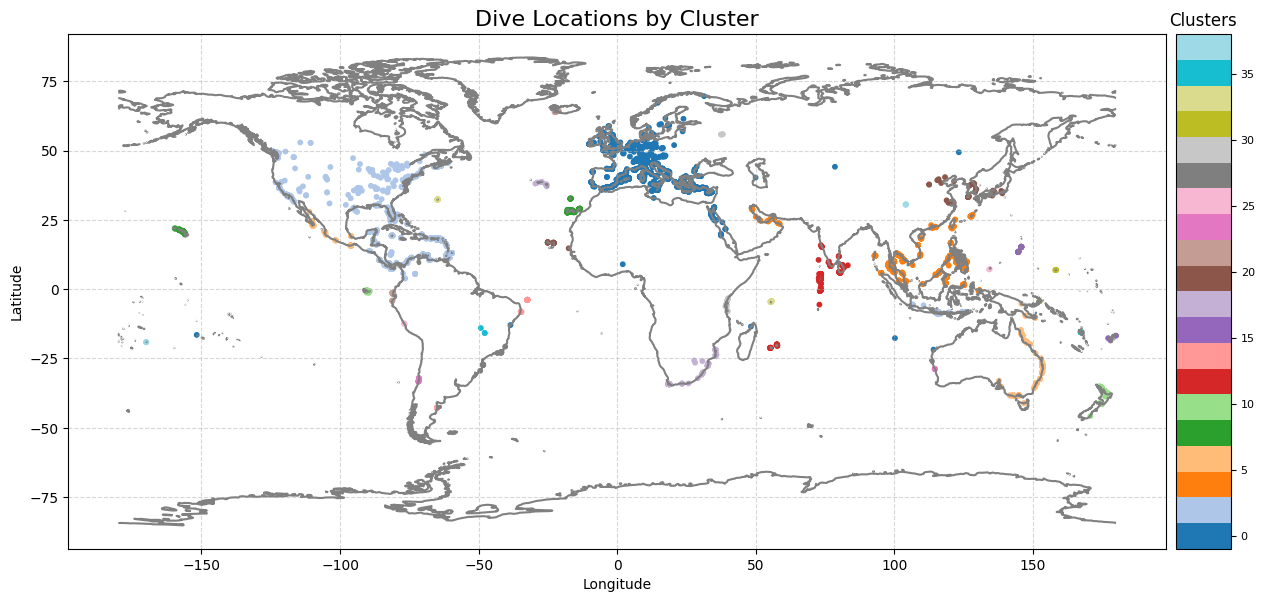

In [78]:
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

# Path to your downloaded shapefile (update this path as needed)
world = gpd.read_file("ne_50m_coastline/ne_50m_coastline.shp")

# Assume 'df' is your DataFrame with dive sites and clusters
num_clusters = df['Cluster'].nunique()
cmap = plt.get_cmap('tab20', num_clusters)

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']))

# Plot the world map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='grey')

# Plot dive locations, coloring by clusters
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
scatter = gdf.plot(column='Cluster', cmap=cmap, markersize=10, ax=ax, legend=True, cax=cax)

# Customize the plot
ax.set_title('Dive Locations by Cluster', fontsize=16)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True, linestyle='--', alpha=0.5)
cax.set_title("Clusters")
cax.tick_params(labelsize=8)

plt.show()


In [11]:
import re

url = "https://www.padi.com/dive-site/malta/hms-maori/"

# Regular expression to match the part after "https://www.padi.com/dive-site/"
pattern = r"https://www\.padi\.com/dive-site/([^/]+)/"

# Extract the matched part
match = re.search(pattern, url)

countries = dive_sites_df['URL']

print(np.unique([re.search(pattern, countries[x]).group(1) for x in range(1,len(countries))]))


['argentina' 'aruba' 'australia' 'austria' 'azerbaijan' 'bahamas'
 'barbados' 'belgium' 'belize' 'benin' 'bermuda' 'bonaire' 'brazil'
 'british-indian-ocean-territory' 'british-virgin-islands' 'brunei'
 'bulgaria' 'cambodia' 'canada' 'cape-verde' 'cayman-islands' 'chile'
 'china' 'colombia' 'costa-rica' 'croatia' 'curacao' 'cyprus' 'denmark'
 'dominica' 'dominican-republic' 'ecuador' 'egypt' 'el-salvador'
 'federated-states-of-micronesia' 'fiji' 'finland' 'france'
 'french-polynesia' 'germany' 'gibraltar' 'greece' 'grenada' 'guam'
 'honduras' 'hungary' 'iceland' 'india' 'indonesia' 'ireland' 'italy'
 'jamaica' 'japan' 'jordan' 'keeling-islands' 'kenya' 'kuwait' 'latvia'
 'libya' 'luxembourg' 'madagascar' 'malaysia' 'maldives' 'malta' 'mexico'
 'montenegro' 'mozambique' 'netherlands' 'new-zealand' 'niue'
 'northern-mariana-islands' 'norway' 'oman' 'pakistan' 'palau' 'panama'
 'papua-new-guinea' 'peru' 'philippines' 'poland' 'portugal' 'puerto-rico'
 'qatar' 'republic-of-mauritius' 'reun

In [14]:
df[['Name', 'Latitude', 'Longitude', 'Cluster', 'Region']][1:50]

,Name,Latitude,Longitude,Cluster,Region
1,USAT Liberty Shipwreck,-8.27396,115.59307,1,Bali and Nusa Penida
2,Ped,-8.67438,115.51499,1,Bali and Nusa Penida
3,Manta Point,-8.79547,115.52553,1,Bali and Nusa Penida
4,THE HOLE / GREEN BAY CAVES,34.99989,34.06868,2,Cyprus and Eastern Mediterranean
5,Tulamben,-8.27341,115.59235,1,Bali and Nusa Penida
6,Cyclops,34.98637,34.07850,2,Cyprus and Eastern Mediterranean
7,C-56 (Juan Escutia) Shipwreck,20.85353,-86.83752,3,Caribbean - Cozumel
8,SS Dunraven Wreck,27.70466,34.12388,4,Northern Red Sea
9,Gilboa Quarry,41.01597,-83.93349,5,Unknown Region
10,Rainbow River,29.04750,-82.45820,5,Unknown Region
